In [1]:
cd ATML-PA-2/DAN/

/kaggle/working/ATML-PA-2/DAN


In [115]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [116]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [118]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns

def evaluate_ds(ds, model, device, domain_name=None, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=32)

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)  
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(Y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()



    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    if domain_name:
        print(f"\n=== Evaluation for {domain_name} Domain ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:\n")
    sns.heatmap(cm, cmap="Blues")
    plt.show()
    print("Classification Report:\n", report)

    return {
        'domain': domain_name,
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [119]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):
    
    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x, [x, f4]

    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    cache_source_train, cache_source_test = torch.utils.data.random_split(cache_source, [0.8,0.2])
    torch.manual_seed(100)
    cache_target_train, cache_target_test = torch.utils.data.random_split(cache_target, [0.8,0.2])

    
    train_workflow(truncated_model, cache_source_train, cache_target_train, cache_target_test, config, device)

    def _forward_impl_2(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x
    truncated_model.forward = types.MethodType(_forward_impl_2, truncated_model)
    
    print(device)
    print("Evaluating on target domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, target[0])

    print("Evaluating on source domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, source)

    print("Evaluating on source domain train set")
    evaluate_ds(cache_source_train, truncated_model, device, source)

    latents_s, _ = get_features(truncated_model[:-1], cache_source_test, batchsize=32, device=device)
    latents_t, _ = get_features(truncated_model[:-1], cache_target_test, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [96]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [97]:
model = resnet_classifier(num_classes=len(classes))

In [10]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


Training:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20

Train loss: 0.79553 | Supervised: 0.79408 | MK-MMD: 0.00144 | Source train acc: 77.87% | Target test acc=40.09%



Training:   5%|▌         | 1/20 [00:13<04:07, 13.04s/it]


Epoch 2/20

Train loss: 0.32032 | Supervised: 0.32027 | MK-MMD: 0.00005 | Source train acc: 85.64% | Target test acc=42.96%



Training:  10%|█         | 2/20 [00:25<03:52, 12.90s/it]


Epoch 3/20

Train loss: 0.20802 | Supervised: 0.20800 | MK-MMD: 0.00002 | Source train acc: 90.75% | Target test acc=46.96%



Training:  15%|█▌        | 3/20 [00:38<03:38, 12.88s/it]


Epoch 4/20

Train loss: 0.15375 | Supervised: 0.15363 | MK-MMD: 0.00012 | Source train acc: 93.87% | Target test acc=45.93%



Training:  20%|██        | 4/20 [00:51<03:25, 12.81s/it]


Epoch 5/20

Train loss: 0.11252 | Supervised: 0.11239 | MK-MMD: 0.00013 | Source train acc: 95.04% | Target test acc=46.28%



Training:  25%|██▌       | 5/20 [01:04<03:12, 12.81s/it]


Epoch 6/20

Train loss: 0.07785 | Supervised: 0.07784 | MK-MMD: 0.00001 | Source train acc: 96.54% | Target test acc=48.45%



Training:  30%|███       | 6/20 [01:17<02:59, 12.82s/it]


Epoch 7/20

Train loss: 0.06624 | Supervised: 0.06594 | MK-MMD: 0.00030 | Source train acc: 97.69% | Target test acc=48.11%



Training:  35%|███▌      | 7/20 [01:30<02:47, 12.86s/it]


Epoch 8/20

Train loss: 0.03825 | Supervised: 0.03822 | MK-MMD: 0.00003 | Source train acc: 98.14% | Target test acc=49.03%



Training:  40%|████      | 8/20 [01:42<02:33, 12.79s/it]


Epoch 9/20

Train loss: 0.03698 | Supervised: 0.03695 | MK-MMD: 0.00003 | Source train acc: 98.64% | Target test acc=47.31%



Training:  45%|████▌     | 9/20 [01:55<02:20, 12.81s/it]


Epoch 10/20

Train loss: 0.03048 | Supervised: 0.02651 | MK-MMD: 0.00397 | Source train acc: 98.96% | Target test acc=48.57%



Training:  50%|█████     | 10/20 [02:08<02:08, 12.83s/it]


Epoch 11/20

Train loss: 0.02627 | Supervised: 0.02627 | MK-MMD: 0.00000 | Source train acc: 99.05% | Target test acc=47.65%



Training:  55%|█████▌    | 11/20 [02:21<01:55, 12.84s/it]


Epoch 12/20

Train loss: 0.01788 | Supervised: 0.01785 | MK-MMD: 0.00003 | Source train acc: 99.17% | Target test acc=47.88%



Training:  60%|██████    | 12/20 [02:34<01:42, 12.84s/it]


Epoch 13/20

Train loss: 0.01382 | Supervised: 0.01381 | MK-MMD: 0.00001 | Source train acc: 99.29% | Target test acc=48.11%



Training:  65%|██████▌   | 13/20 [02:46<01:29, 12.81s/it]


Epoch 14/20

Train loss: 0.01265 | Supervised: 0.01255 | MK-MMD: 0.00010 | Source train acc: 99.55% | Target test acc=47.54%



Training:  70%|███████   | 14/20 [03:00<01:17, 12.93s/it]


Epoch 15/20

Train loss: 0.01343 | Supervised: 0.01343 | MK-MMD: 0.00001 | Source train acc: 99.62% | Target test acc=48.00%



Training:  75%|███████▌  | 15/20 [03:12<01:04, 12.95s/it]


Epoch 16/20

Train loss: 0.01146 | Supervised: 0.01121 | MK-MMD: 0.00025 | Source train acc: 99.65% | Target test acc=47.65%



Training:  80%|████████  | 16/20 [03:25<00:51, 12.96s/it]


Epoch 17/20

Train loss: 0.00821 | Supervised: 0.00820 | MK-MMD: 0.00000 | Source train acc: 99.67% | Target test acc=49.14%



Training:  85%|████████▌ | 17/20 [03:38<00:38, 12.90s/it]


Epoch 18/20

Train loss: 0.00904 | Supervised: 0.00900 | MK-MMD: 0.00004 | Source train acc: 99.68% | Target test acc=48.22%



Training:  90%|█████████ | 18/20 [03:51<00:25, 12.89s/it]


Epoch 19/20

Train loss: 0.00661 | Supervised: 0.00656 | MK-MMD: 0.00005 | Source train acc: 99.70% | Target test acc=48.57%



Training:  95%|█████████▌| 19/20 [04:04<00:12, 12.83s/it]


Epoch 20/20

Train loss: 0.00661 | Supervised: 0.00660 | MK-MMD: 0.00000 | Source train acc: 99.68% | Target test acc=48.91%



Training: 100%|██████████| 20/20 [04:17<00:00, 12.87s/it]

cuda
Evaluating on target domain test set



=== Evaluation for Clipart Domain ===
Accuracy: 48.91%
Confusion Matrix:



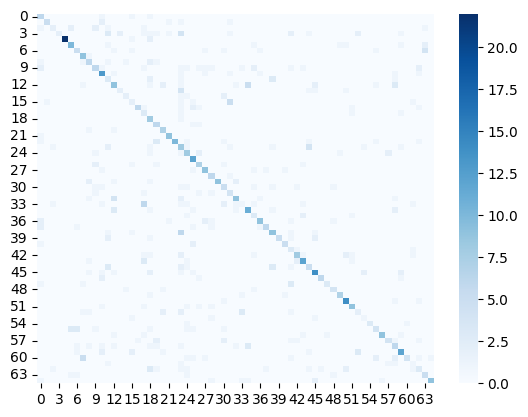

Classification Report:
               precision    recall  f1-score   support

           0     0.3158    0.6667    0.4286         9
           1     0.8333    0.5000    0.6250        10
           2     0.4000    0.2000    0.2667        10
           3     1.0000    0.0909    0.1667        22
           4     1.0000    0.8800    0.9362        25
           5     0.6250    0.5882    0.6061        17
           6     0.4167    0.3333    0.3704        15
           7     0.5000    0.9000    0.6429        10
           8     0.4000    0.4615    0.4286        13
           9     0.4286    0.2727    0.3333        22
          10     0.4815    0.6500    0.5532        20
          11     0.1667    0.3000    0.2143        10
          12     0.3913    0.3462    0.3673        26
          13     0.5000    0.2222    0.3077         9
          14     0.5000    0.3333    0.4000         6
          15     0.2000    0.1818    0.1905        11
          16     0.8571    0.4615    0.6000        13
   

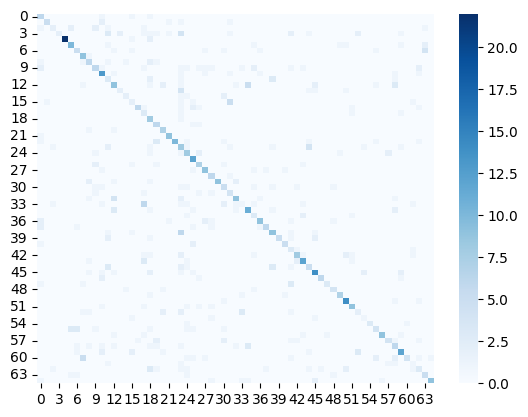

Classification Report:
               precision    recall  f1-score   support

           0     0.3158    0.6667    0.4286         9
           1     0.8333    0.5000    0.6250        10
           2     0.4000    0.2000    0.2667        10
           3     1.0000    0.0909    0.1667        22
           4     1.0000    0.8800    0.9362        25
           5     0.6250    0.5882    0.6061        17
           6     0.4167    0.3333    0.3704        15
           7     0.5000    0.9000    0.6429        10
           8     0.4000    0.4615    0.4286        13
           9     0.4286    0.2727    0.3333        22
          10     0.4815    0.6500    0.5532        20
          11     0.1667    0.3000    0.2143        10
          12     0.3913    0.3462    0.3673        26
          13     0.5000    0.2222    0.3077         9
          14     0.5000    0.3333    0.4000         6
          15     0.2000    0.1818    0.1905        11
          16     0.8571    0.4615    0.6000        13
   

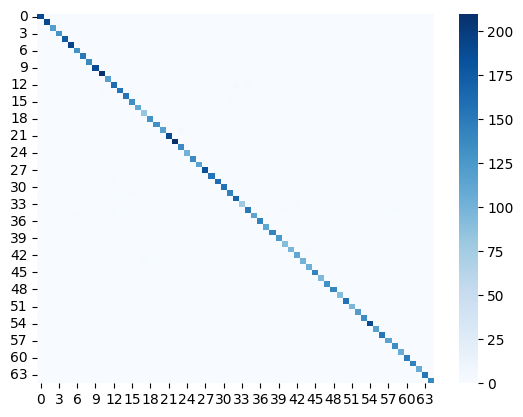

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9895    0.9947       190
           1     1.0000    1.0000    1.0000       191
           2     1.0000    1.0000    1.0000       120
           3     1.0000    1.0000    1.0000       128
           4     1.0000    1.0000    1.0000       175
           5     1.0000    1.0000    1.0000       194
           6     0.9924    1.0000    0.9962       130
           7     1.0000    1.0000    1.0000       151
           8     0.9928    1.0000    0.9964       137
           9     1.0000    1.0000    1.0000       189
          10     0.9952    1.0000    0.9976       209
          11     1.0000    1.0000    1.0000       118
          12     0.9699    0.9758    0.9728       165
          13     1.0000    0.9936    0.9968       156
          14     1.0000    1.0000    1.0000       154
          15     0.9925    0.9925    0.9925       134
          16     1.0000    1.0000    1.0000       111
   

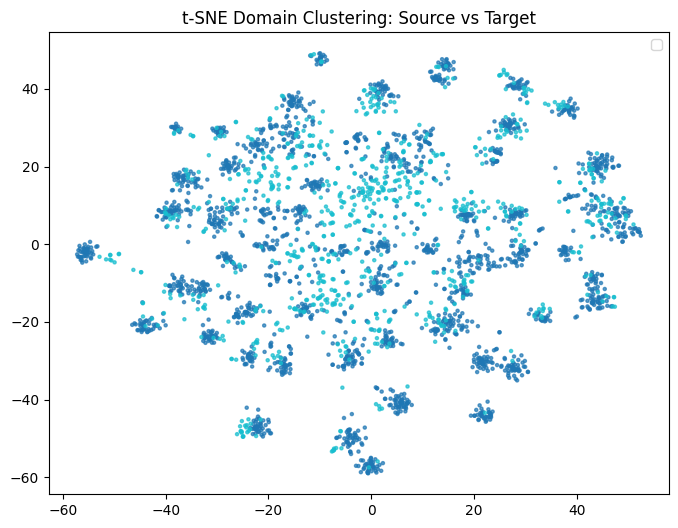

In [121]:
config = {'epochs': 20, 
          'lr':1e-3, 
          'batch_size':64, 
          'weight_decay':1e-4, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':128.0
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

NameError: name 'cache_source_train' is not defined